In [1]:
import os
import random 

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, merge
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.datasets import mnist
from keras import backend as K

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
# Many of these functions are modified from @osh's implementation of a
# deep convolutional generative adversarial network and can be viewed
# here: https://github.com/osh/KerasGAN

def plot_mnist(vector):
    """
    Expects a numpy array input of length 748
    """
    vector = vector.reshape((28, 28))
    plt.imshow(vector, cmap='gray')
    plt.show()

def plot_generated(z_input, generator_model, examples=9,
                   custom_input=False, plot_dim=(3,3), size=(10,10)):
    """
    Draws randomly from a {0,1} uniform distribution, uses the
    generative model to build predictions from the input noise
    and plots the generated examples
    """
    if custom_input:
        noise = z_input
    else:
        noise = np.random.uniform(0, 1, size=[examples, z_input])
    
    generated_images = generator_model.predict(noise)

    fig = plt.figure(figsize=size)
    for i in range(examples):
        plt.subplot(plot_dim[0], plot_dim[1], i+1)
        img = generated_images[i, :]
        img = img.reshape((28, 28))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
        
    return fig

def plot_metrics(metrics):
    """
    Plots loss and F score over training epochs
    """
    plt.figure(figsize=(10,8))
    plt.plot(metrics["d"], label='discriminitive loss')
    plt.plot(metrics["g"], label='generative loss')
    plt.plot(metrics["f"], label='F score')
    plt.legend()
    plt.show()

def generative_adversarial_network(generator_model, discriminator_model):
    """
    Compiling a generator and discriminator Sequential() models to build the
    generative adversarial framework
    """
    gan_model = Sequential()
    gan_model.add(generator_model)
    discriminator_model.trainable = False
    gan_model.add(discriminator_model)
    return gan_model

def train_for_n(z_input, generator_model, discriminator_model, gan_model,
                loss_dict, X_train, z_training_figures=None, z_group=None,
                z_plot_freq=100, visualize_train=False, epoch=500,
                plot_freq=25, batch=10):
    """
    Trains the GAN over input epochs according to batch sizes and will
    periodically display the training performance.
    
    Arguments:
    z_input - an int corresponding to the length of the random noise vector
    generator_model - a Sequential() Keras model with output dim 784
    discriminator_model - a Sequential() Keras model with output dim 1
    gan_model - combined Sequential() model of the generator and discriminator
    loss_dict - a dictionary that stores the results of each training epoch
    X_train - the training data X matrix
    plot_freq - after how many epochs a performance plot is displayed
    batch - how many samples input into training on each epoch
    
    Output:
    Trains the discriminator and generator simultaneously with the
    generator optimized to generate fake samples
    """
    with tqdm(total=epoch) as pbar:
        for e in range(epoch):  
            pbar.update(1)

            # Make random generative images   
            noise = np.random.uniform(0, 1, size=[batch, z_input])
            generated_images = generator_model.predict_on_batch(noise)
            
            # Generate consistent z vectors to visualize training process
            if visualize_train and e < 500:
                if e%z_plot_freq == z_plot_freq-1:
                    fig = plot_generated(z_input=z_group, custom_input=visualize_train,
                                         generator_model=generator_model)
                    z_training_figures.append(fig)
            
            # Subset random batch of training data
            rand_train_index = np.random.randint(0, X_train.shape[0], size=batch)
            image_batch = X_train[rand_train_index, :] 

            # Combine generated images with training data
            X = np.concatenate((image_batch, generated_images))
            y = np.zeros(int(2*batch))
            y[batch:] = 1  # Fake images get 1, real images get 0
            y = y.astype(int)

            # Train the discriminator to correctly detect fake images from real
            discriminator.trainable = True
            d_loss, d_f_score = discriminator_model.train_on_batch(x=X, y=y)
            discriminator.trainable = False

            # Coerce generator to try to make real samples
            noise = np.random.uniform(0, 1, size=[batch, z_input])
            y = np.zeros(batch)
            y = y.astype(int)
            g_loss = gan_model.train_on_batch(x=noise, y=y)

            loss_dict["d"].append(d_loss)
            loss_dict["g"].append(g_loss)
            loss_dict["f"].append(d_f_score) 

            # Update plots
            if e%plot_freq == plot_freq-1:
                plot_metrics(loss_dict)
                plot_generated(z_input=z_input, generator_model=generator_model)

In [4]:
random.seed(123)

In [5]:
# Define constants
z_input_vector = 100
n_train_samples = 50000
z_plot_freq = 25
epoch = 6000
plot_freq = 500
batch = 300

generator_optimizer = SGD(lr=0.1, momentum=0.3, decay=1e-5)
discriminator_optimizer = SGD(lr=0.1, momentum=0.1, decay=1e-5)
gan_optimizer = SGD(lr=0.1, momentum=0.3)

In [6]:
# Construct the Generator
# Mini-batch normalization (Ioffe and Szegedy 2015) is essential in this step  because it
# prevents the generator from collapsing into a unviversal output and allows for faster
# training (see Salimans et al. 2016). The model is a traditional MLP GAN similarly
# proposed by Goodfellow et al. 2014
generator = Sequential()
generator.add(Dense(input_dim=100, output_dim=1600, init='glorot_uniform'))
generator.add(BatchNormalization(mode=0))
generator.add(LeakyReLU(alpha=0.3))
generator.add(Dense(1200, init='glorot_uniform'))
generator.add(BatchNormalization(mode=0))
generator.add(LeakyReLU(alpha=0.3))
generator.add(Dense(1000, init='glorot_uniform'))
generator.add(BatchNormalization(mode=0))
generator.add(LeakyReLU(alpha=0.3))
generator.add(Dense(784, init='glorot_uniform', activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 1600)          161600      dense_input_1[0][0]              
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 1600)          3200        dense_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 1600)          0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1200)          1921200     leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [7]:
# Discriminator Model
discriminator = Sequential()
discriminator.add(Dense(input_dim=784, output_dim=240, init='glorot_uniform'))
discriminator.add(LeakyReLU(alpha=0.3))
discriminator.add(Dense(output_dim=240, init='glorot_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
discriminator.add(Dense(output_dim=240, init='glorot_uniform', activation='relu'))
discriminator.add(Dropout(0.2))
discriminator.add(Dense(1, init='glorot_uniform'))
discriminator.add(Activation('sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer,
                      metrics=['fbeta_score'])
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 240)           188400      dense_input_2[0][0]              
____________________________________________________________________________________________________
leakyrelu_4 (LeakyReLU)          (None, 240)           0           dense_5[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 240)           57840       leakyrelu_4[0][0]                
____________________________________________________________________________________________________
leakyrelu_5 (LeakyReLU)          (None, 240)           0           dense_6[0][0]                    
___________________________________________________________________________________________

In [8]:
# Build the gan framework
gan = generative_adversarial_network(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer)
gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
sequential_1 (Sequential)        (None, 784)           4076184                                      
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 1)             0           dense_4[0][0]                    
Total params: 4380505
____________________________________________________________________________________________________


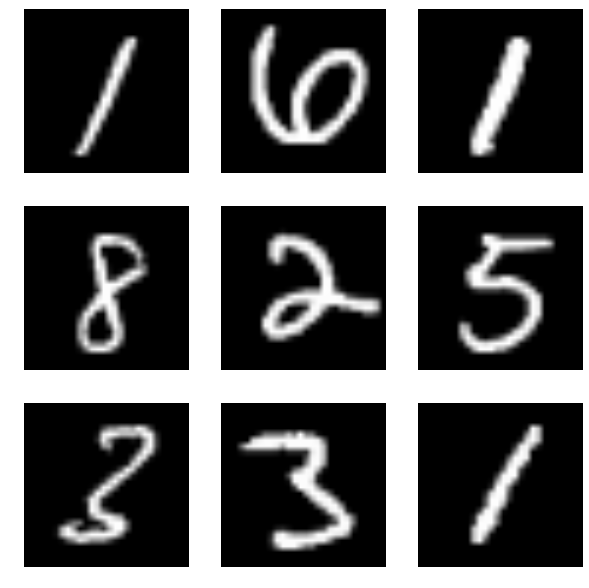

In [9]:
# Load the MNIST data and plot a couple examples
(X_train, y_train), (X_test, y_test) = mnist.load_data()

random_mnist_idx = random.sample(range(0,X_train.shape[0]), 9)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = X_train[random_mnist_idx[i], :].reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.savefig(os.path.join('figures', 'random_MNIST_examples.png'))

In [10]:
# Process the input data
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 784)
60000 train samples
10000 test samples


In [11]:
train_index = random.sample(range(0, X_train.shape[0]), n_train_samples)
X_real = X_train[train_index,:]
noise_gen = np.random.uniform(0, 1, size=[n_train_samples, z_input_vector])
noise_gen.shape

(50000, 100)

In [12]:
# Create a z matrix to track throughout training process
z_group_matrix = np.random.uniform(0, 1, size=[9, z_input_vector])
z_training_figures = []

In [13]:
initial_generated_images = generator.predict_on_batch(noise_gen)

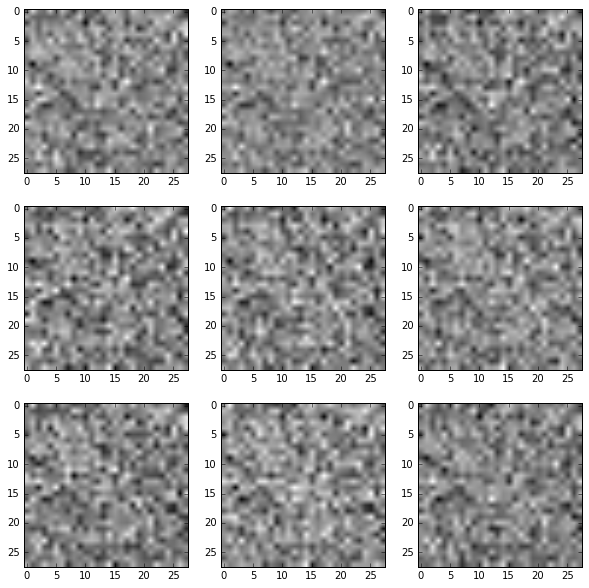

In [14]:
# Example randomly generated images before training
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    x = initial_generated_images[i].reshape((28, 28))
    plt.imshow(x, cmap='gray')
plt.savefig(os.path.join('figures', 'random_z_vectors.png'))

In [15]:
# Combine real and fake data to pretrain the classifier
X = np.concatenate((X_real, initial_generated_images))
n = X_real.shape[0]
y = np.zeros(int(2*n))
y[n:] = 1
y = y.astype(int)

discriminator.trainable = True
discriminator.fit(X, y, nb_epoch=1, batch_size=300)

# Determine the accuracy of the model
y_hat = discriminator.predict_on_batch(X)
accuracy = (2*n - np.sum(np.abs(y - y_hat.round().transpose()))) / (2*n)
print('Accuracy = {}'.format(accuracy))

Epoch 1/1
100000/100000 [==============================] - 4s - loss: 0.0104 - fbeta_score: 0.9976     
Accuracy = 1.0


  0%|          | 25/6000 [00:06<24:06,  4.13it/s]

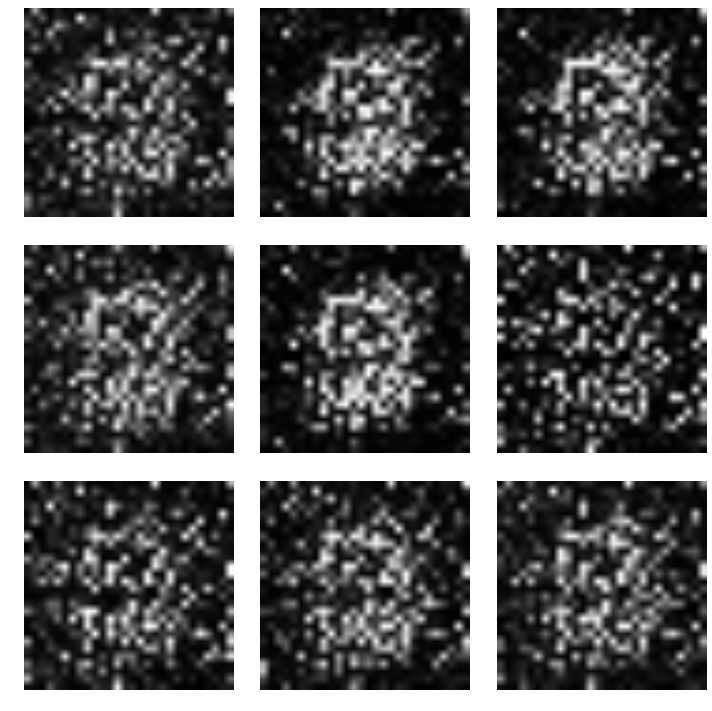

  1%|          | 50/6000 [00:12<20:57,  4.73it/s]

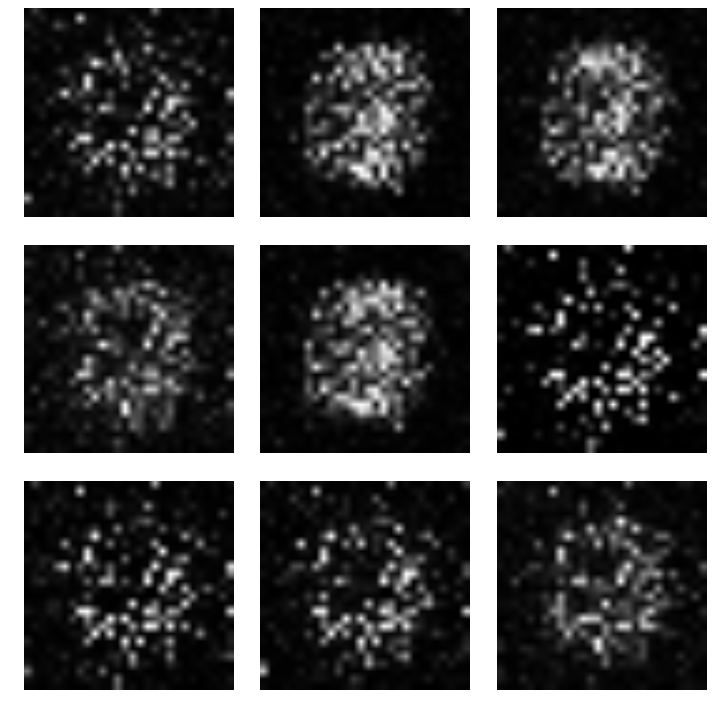

  1%|▏         | 75/6000 [00:18<20:32,  4.81it/s]

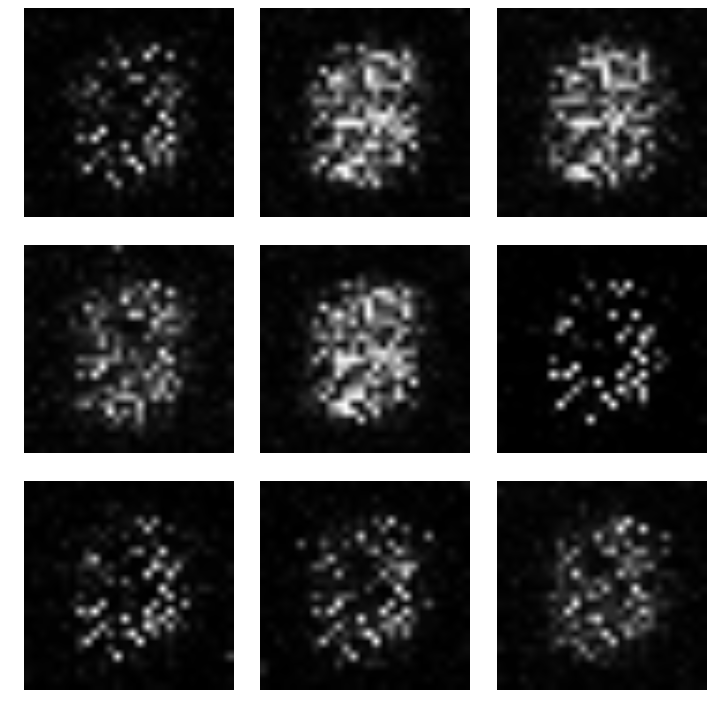

  2%|▏         | 100/6000 [00:25<20:20,  4.83it/s]

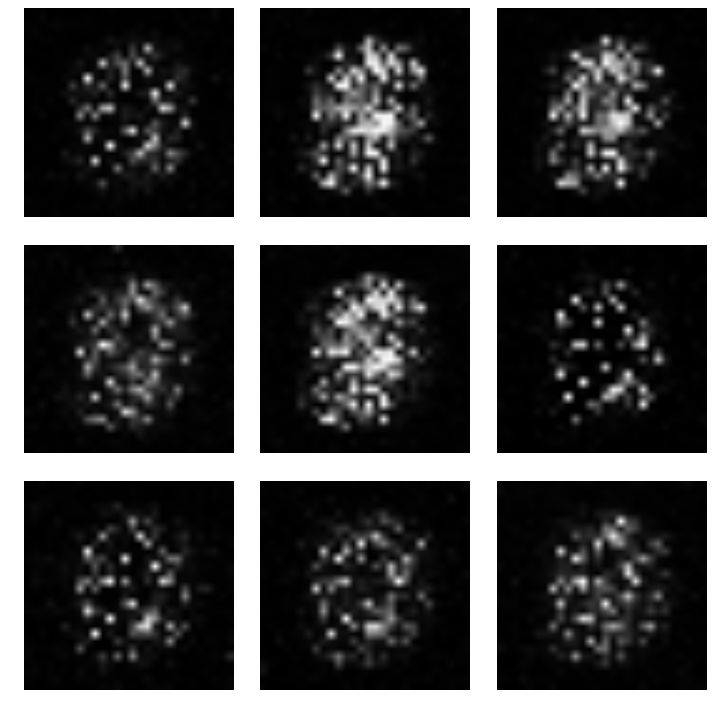

  2%|▏         | 125/6000 [00:31<20:39,  4.74it/s]

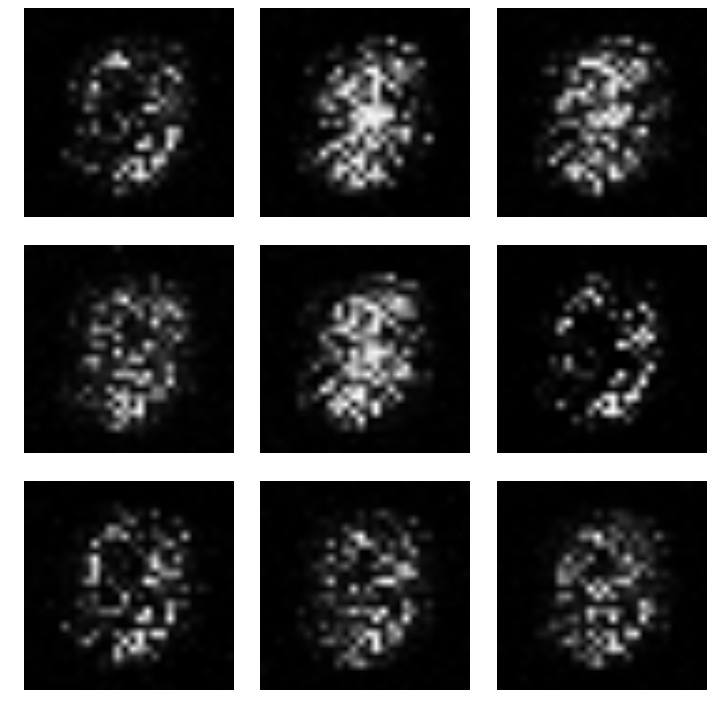

  2%|▎         | 150/6000 [00:36<19:59,  4.88it/s]

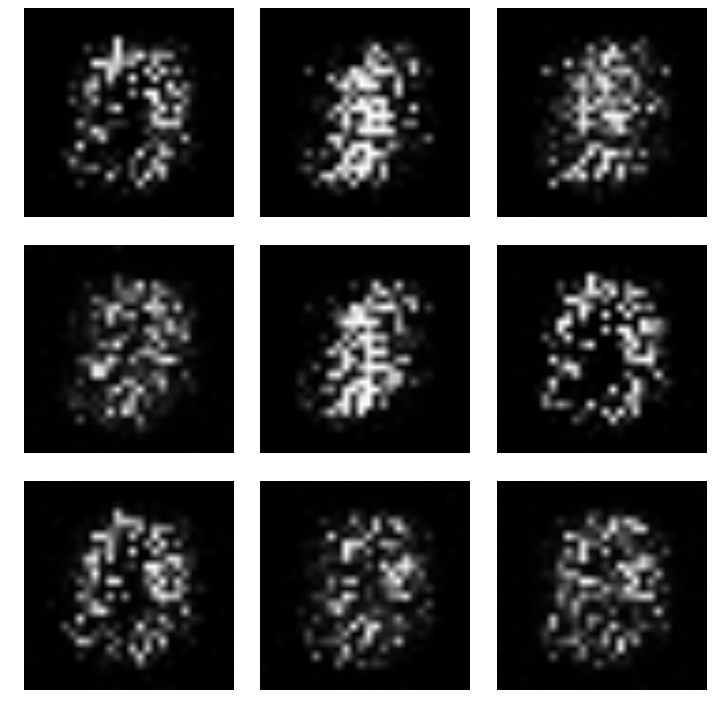

  3%|▎         | 175/6000 [00:42<19:51,  4.89it/s]

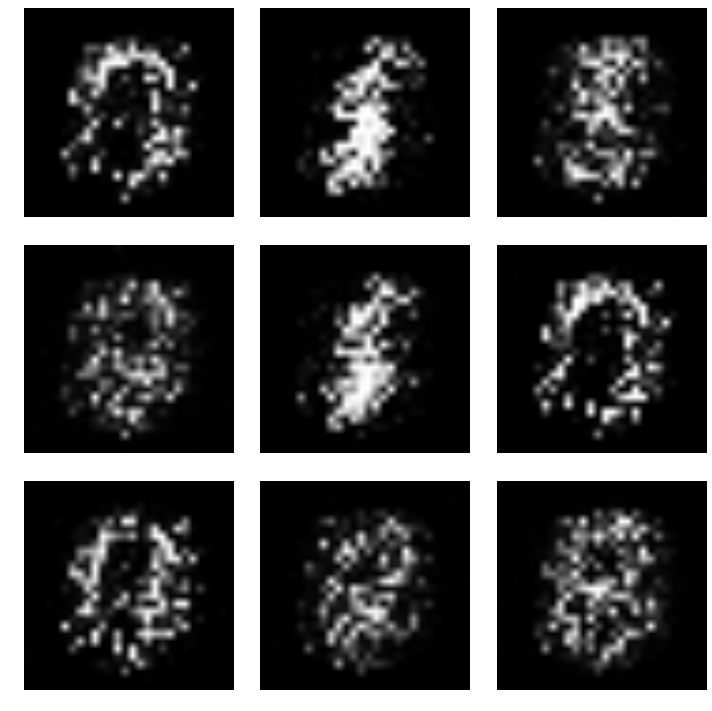

  3%|▎         | 200/6000 [00:48<20:06,  4.81it/s]

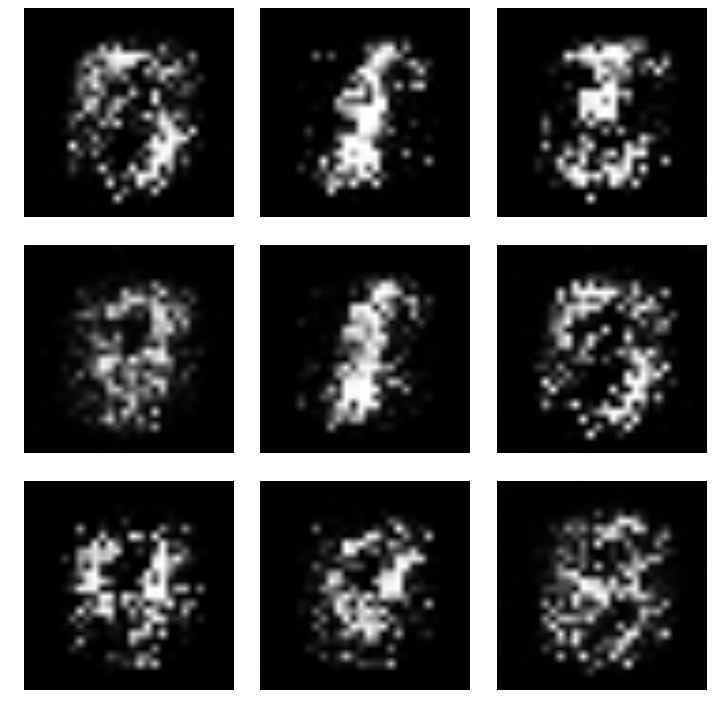

  4%|▍         | 225/6000 [00:54<19:49,  4.85it/s]

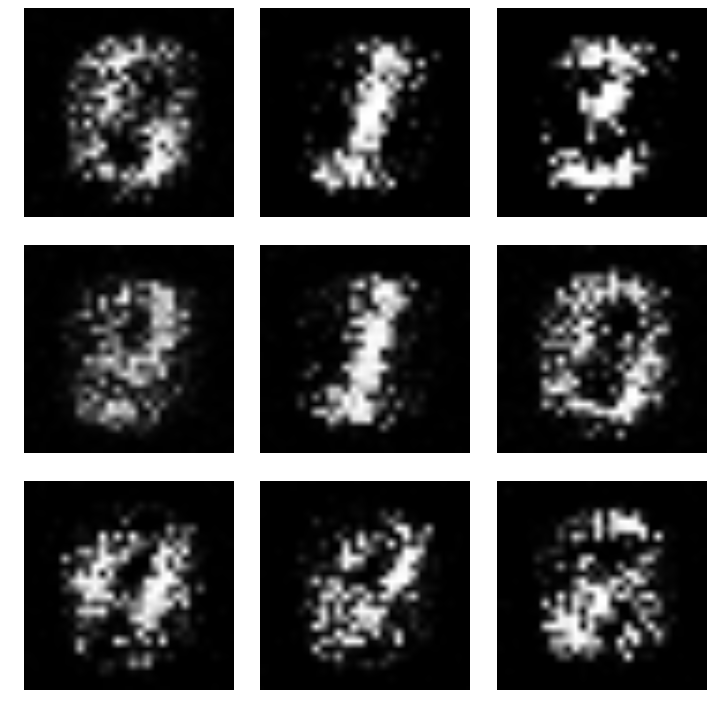

  4%|▍         | 250/6000 [01:00<20:02,  4.78it/s]

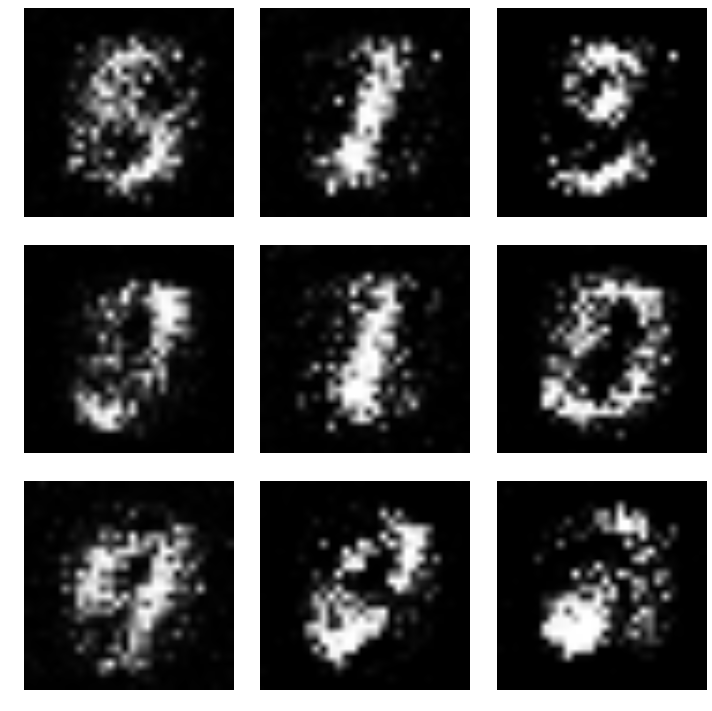

  5%|▍         | 275/6000 [01:06<20:54,  4.56it/s]

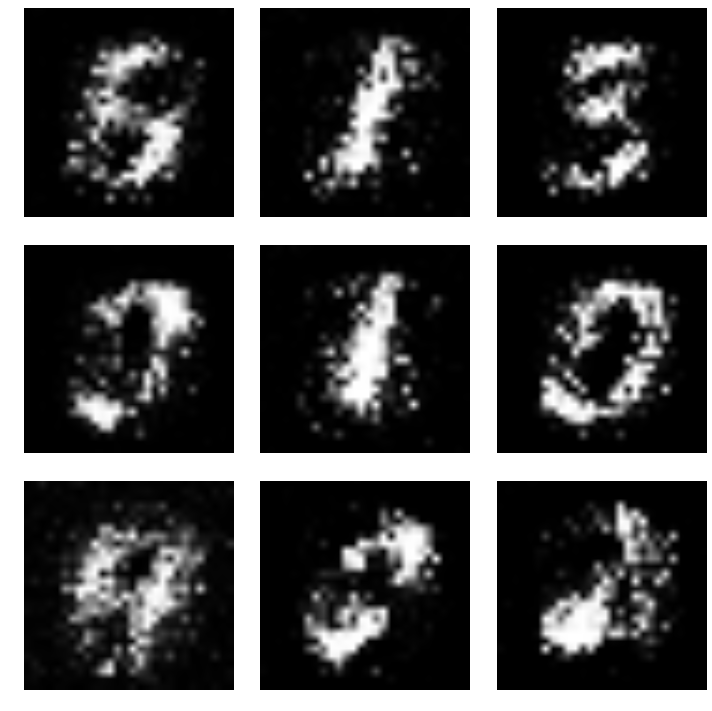

  5%|▌         | 300/6000 [01:12<20:28,  4.64it/s]

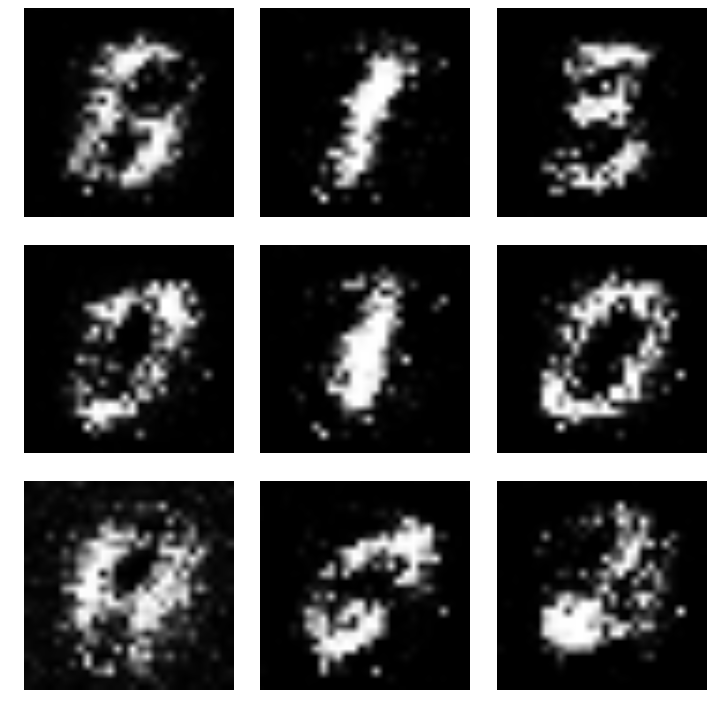

  5%|▌         | 325/6000 [01:18<19:24,  4.88it/s]

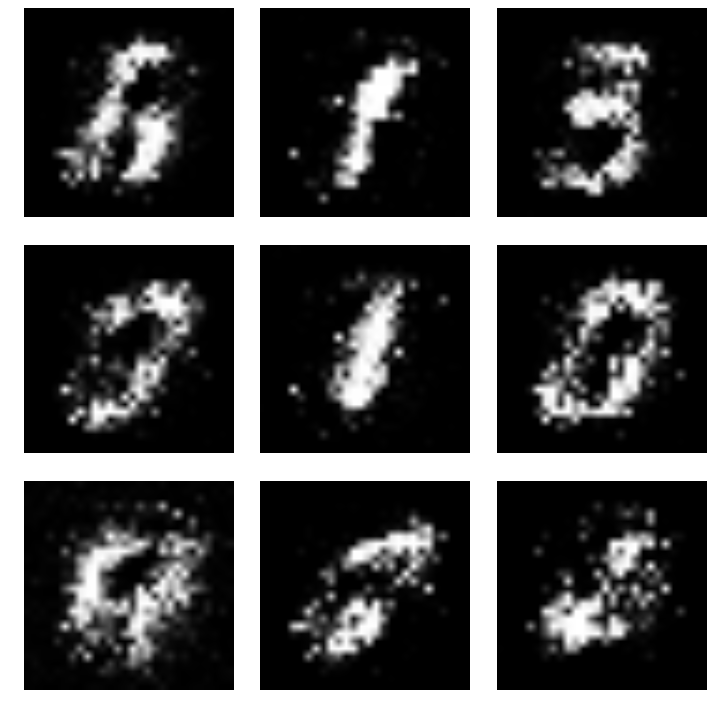

  6%|▌         | 350/6000 [01:24<19:37,  4.80it/s]

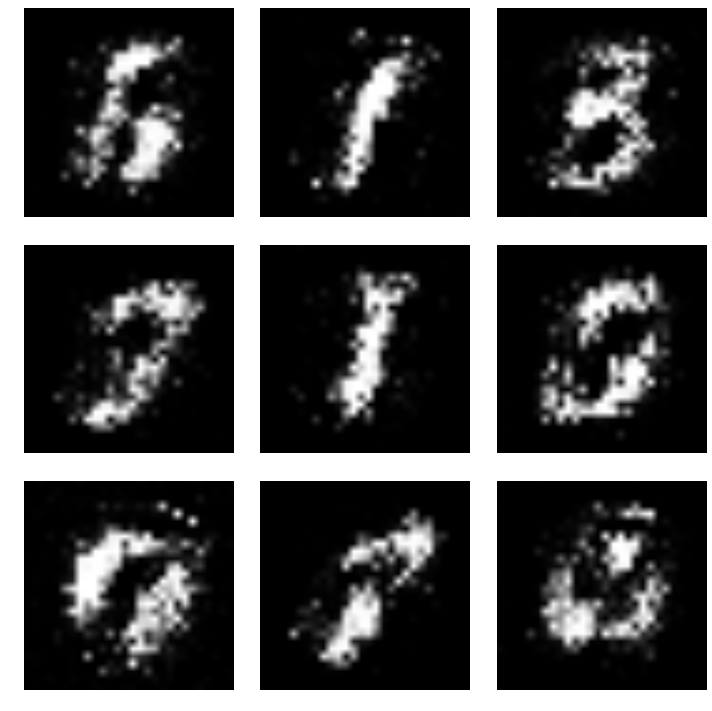

  6%|▋         | 375/6000 [01:30<19:29,  4.81it/s]

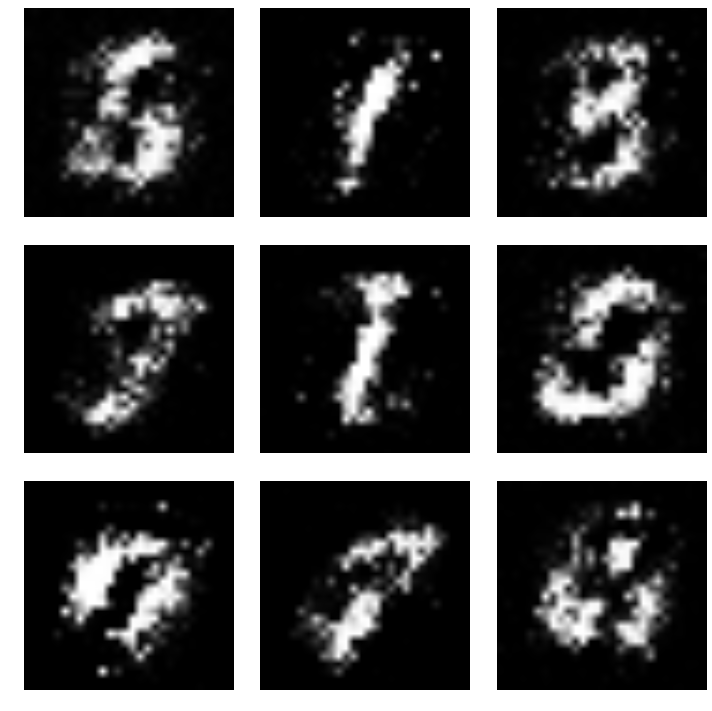

  7%|▋         | 400/6000 [01:36<19:30,  4.78it/s]

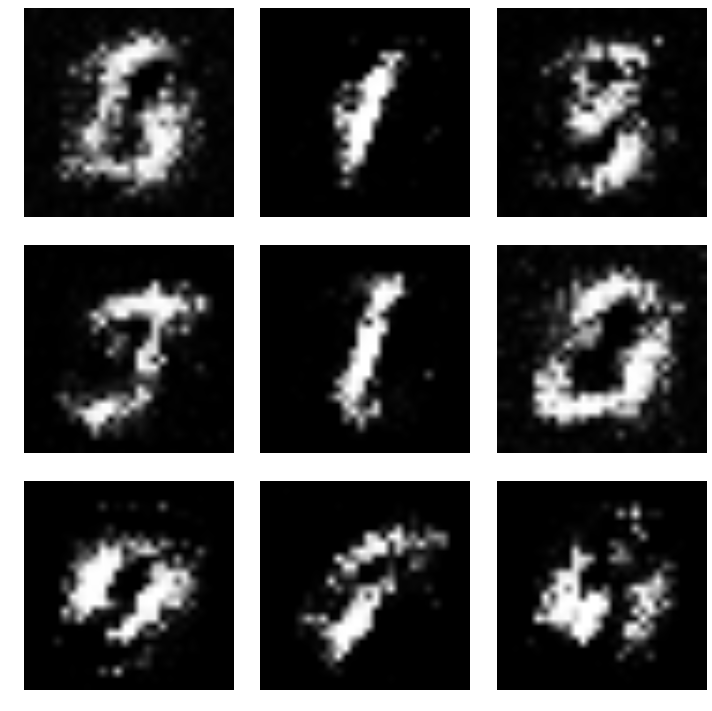

  7%|▋         | 425/6000 [01:42<19:36,  4.74it/s]

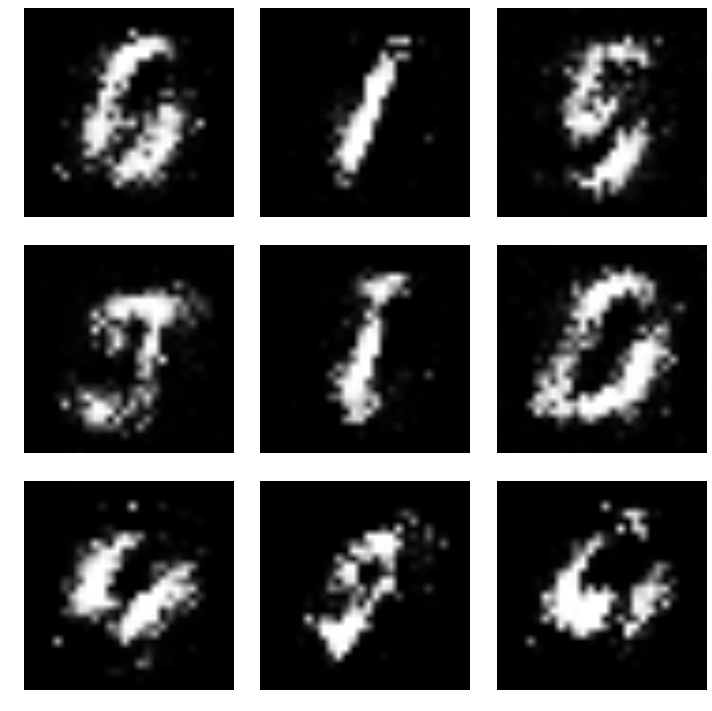

  8%|▊         | 450/6000 [01:48<19:28,  4.75it/s]

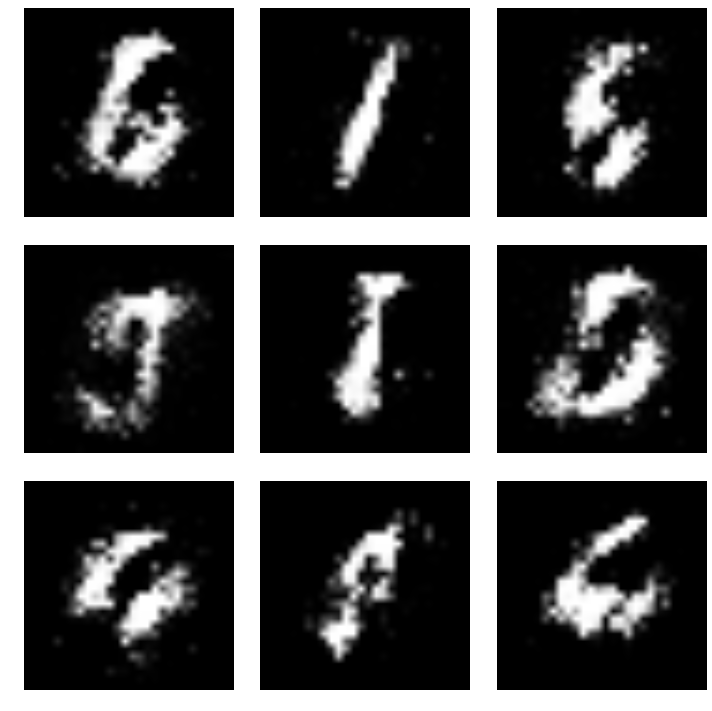

  8%|▊         | 475/6000 [01:54<19:08,  4.81it/s]

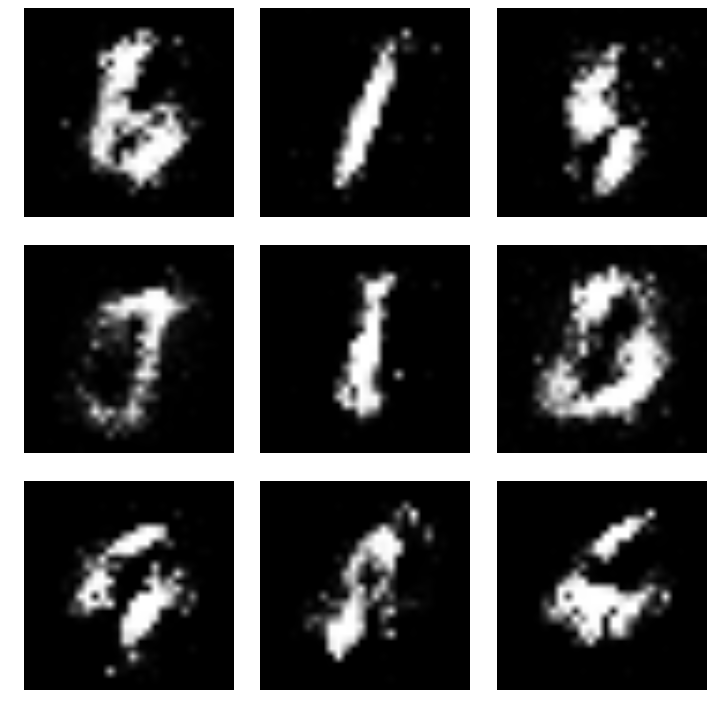

  8%|▊         | 500/6000 [02:00<19:33,  4.69it/s]

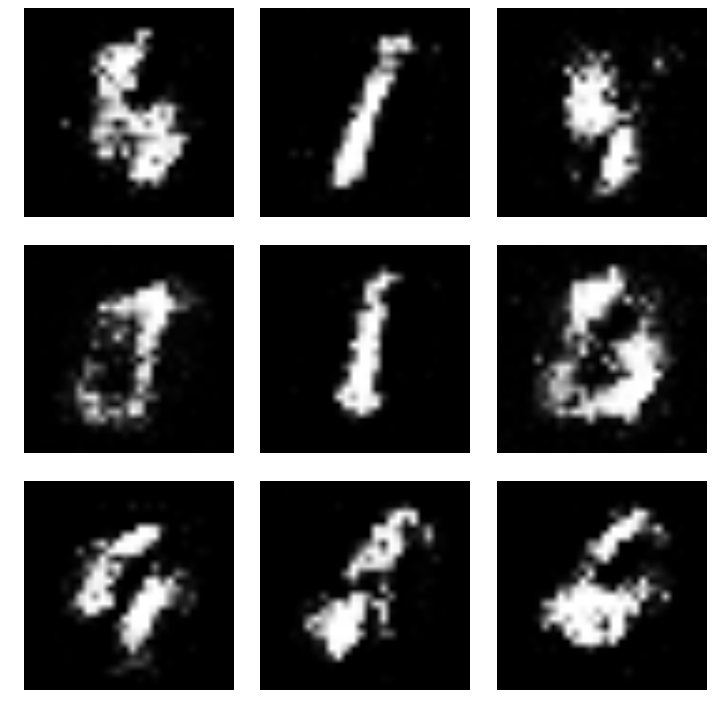

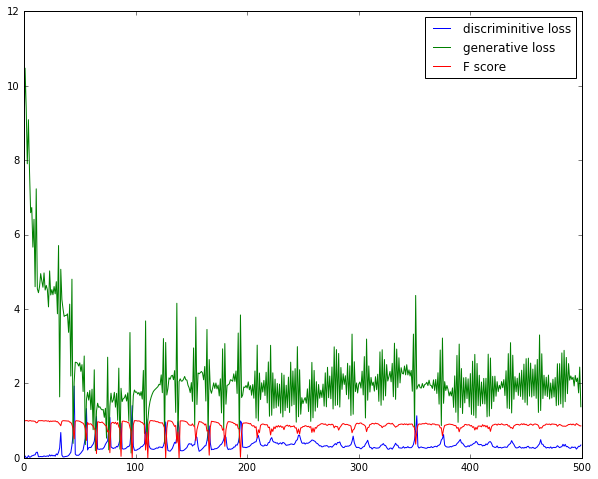

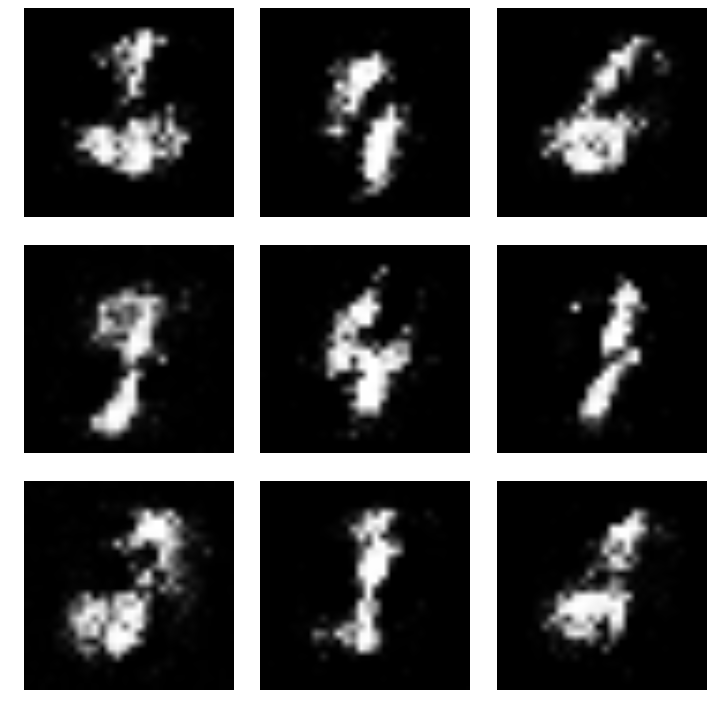

 17%|█▋        | 1000/6000 [03:50<17:31,  4.76it/s]

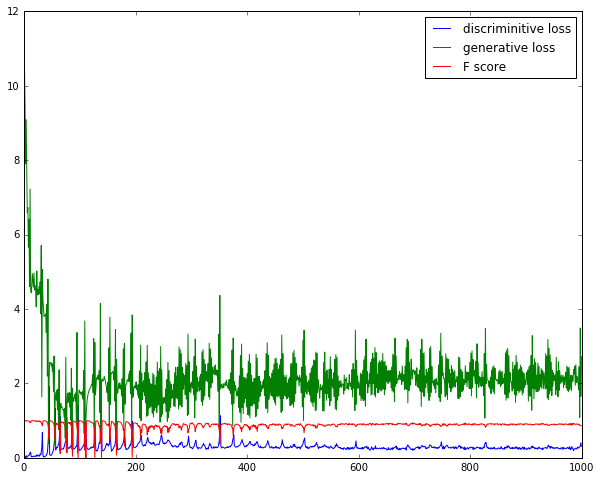

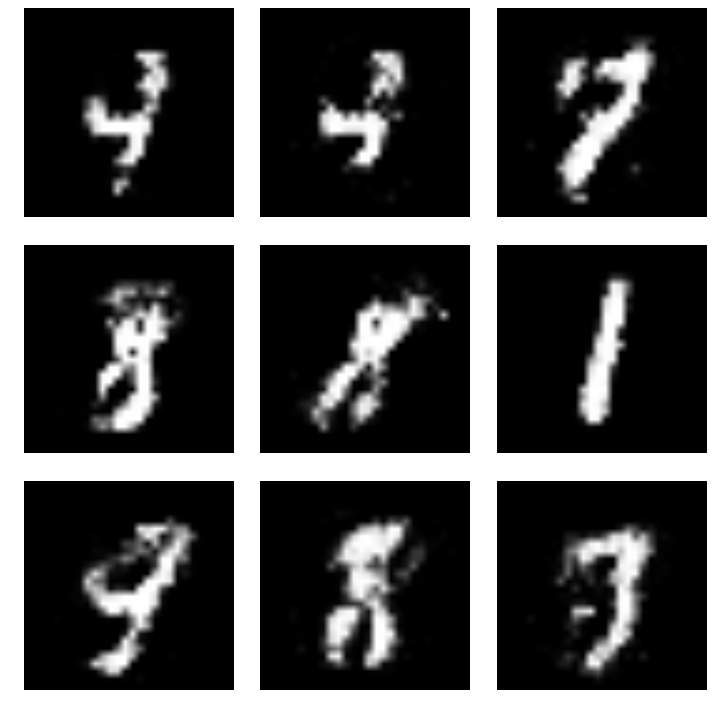

 25%|██▌       | 1500/6000 [05:37<15:41,  4.78it/s]

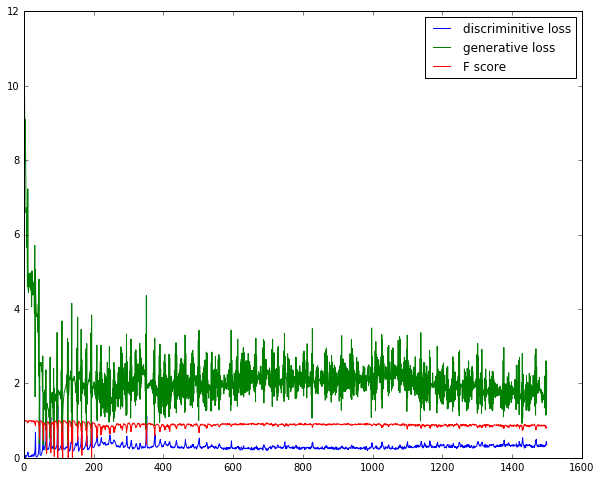

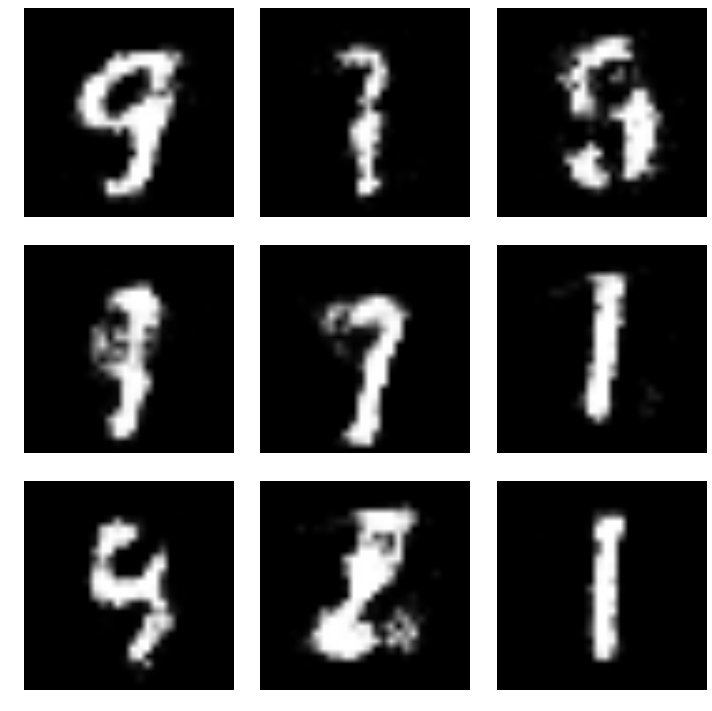

 33%|███▎      | 2000/6000 [07:31<14:00,  4.76it/s]

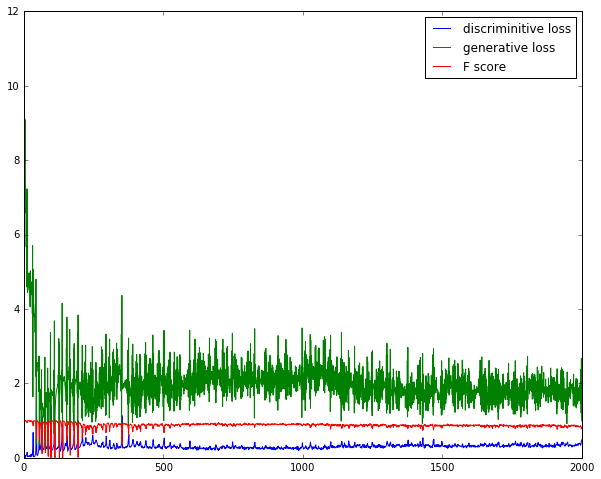

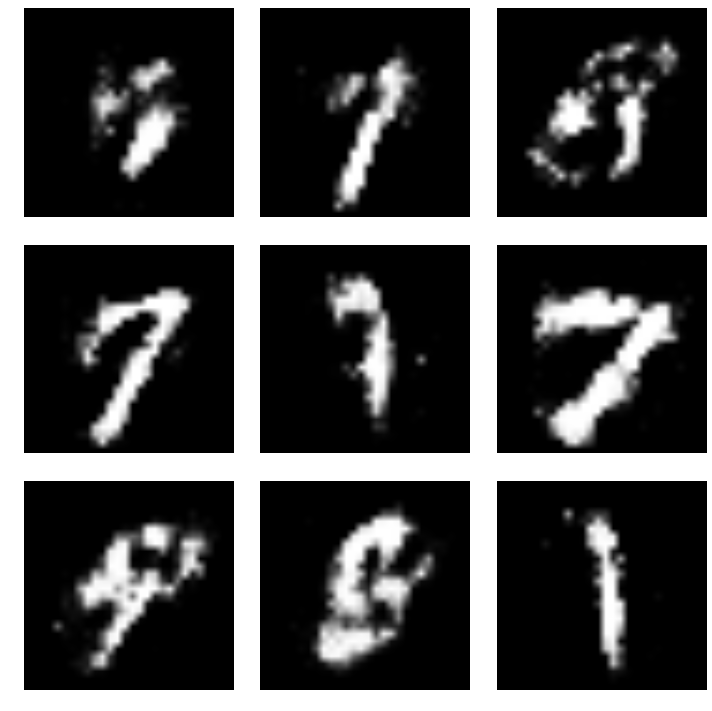

 42%|████▏     | 2500/6000 [09:23<12:21,  4.72it/s]

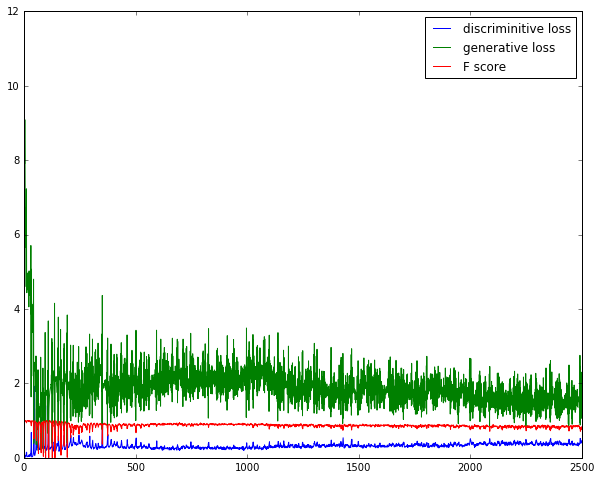

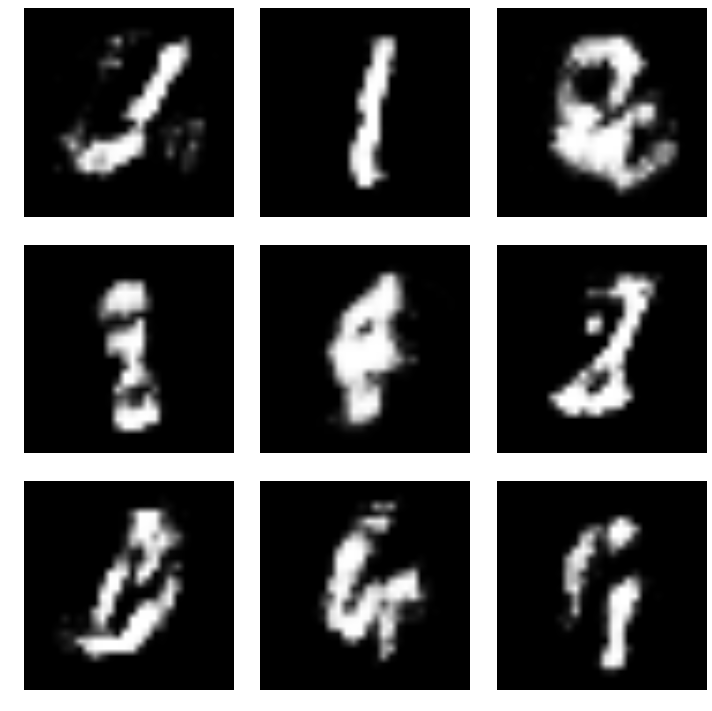

 50%|█████     | 3000/6000 [11:10<10:18,  4.85it/s]

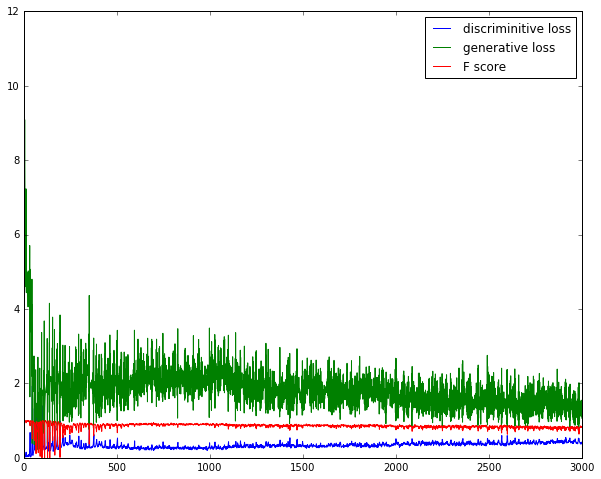

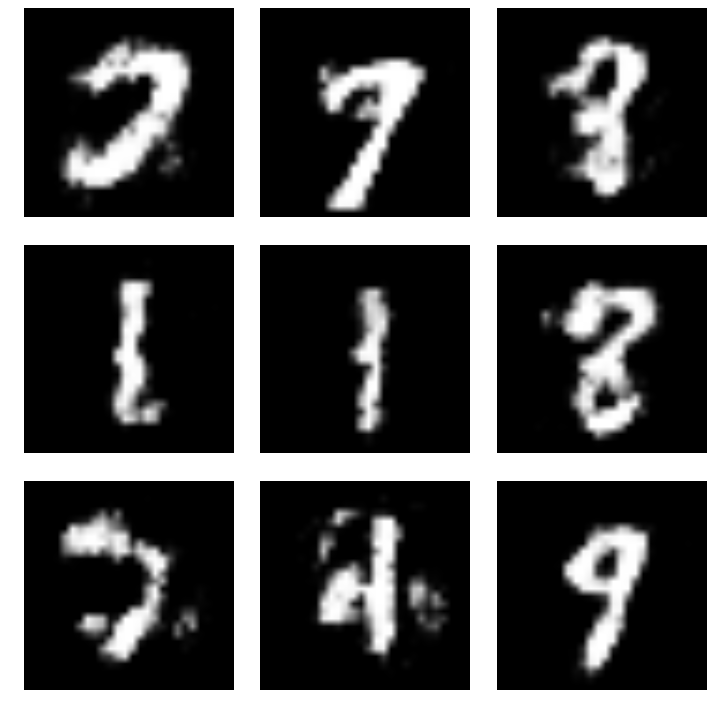

 58%|█████▊    | 3500/6000 [13:02<10:52,  3.83it/s]

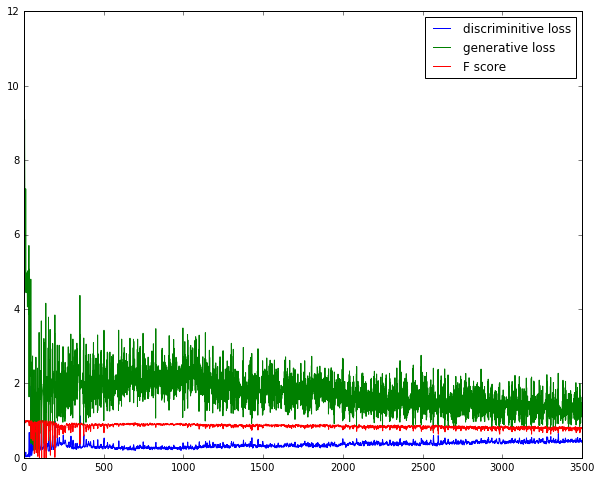

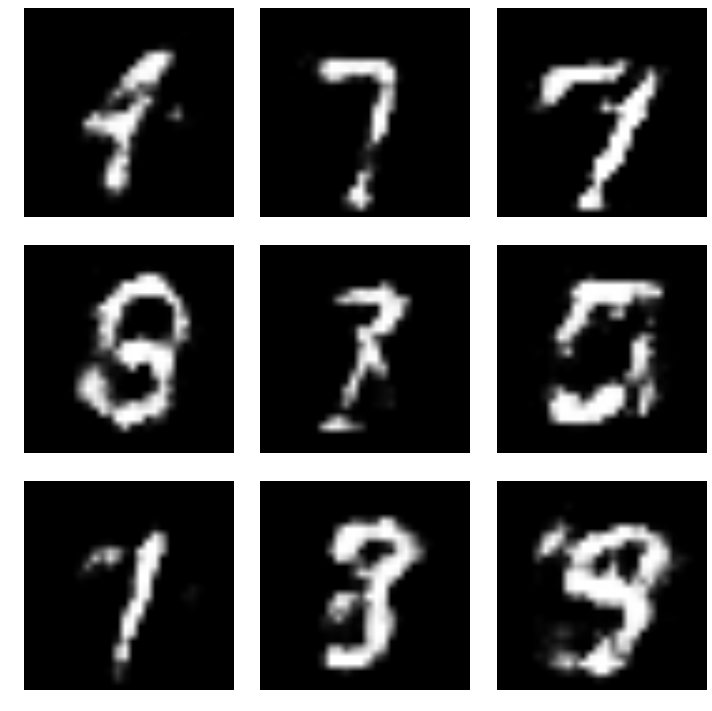

 67%|██████▋   | 4000/6000 [14:53<07:13,  4.61it/s]

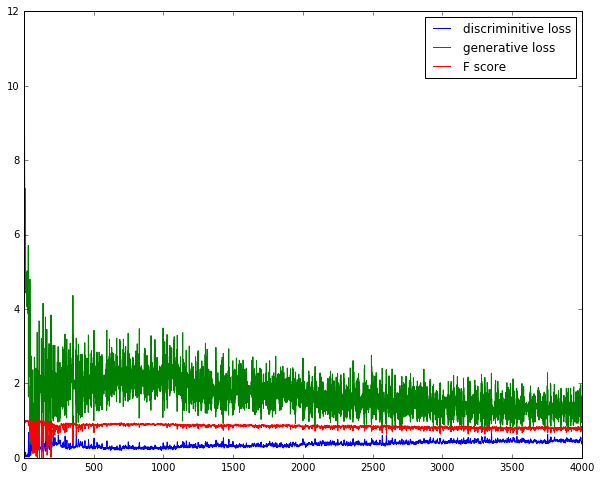

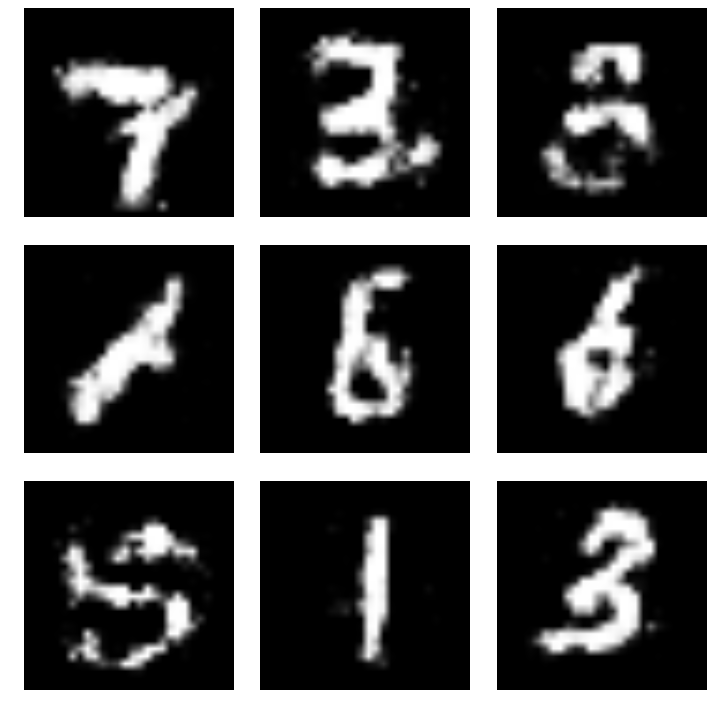

 75%|███████▌  | 4500/6000 [16:43<05:25,  4.61it/s]

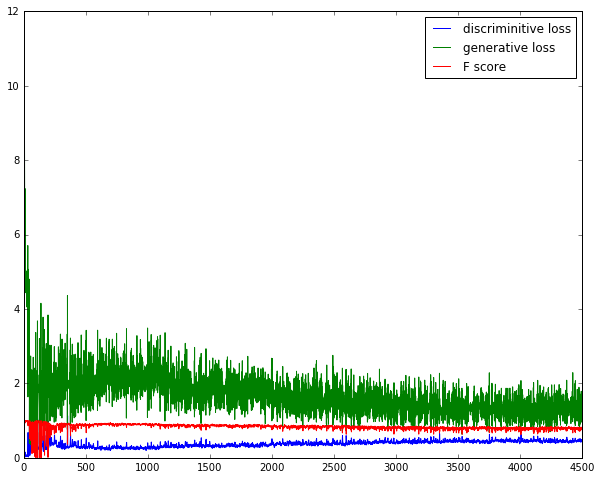

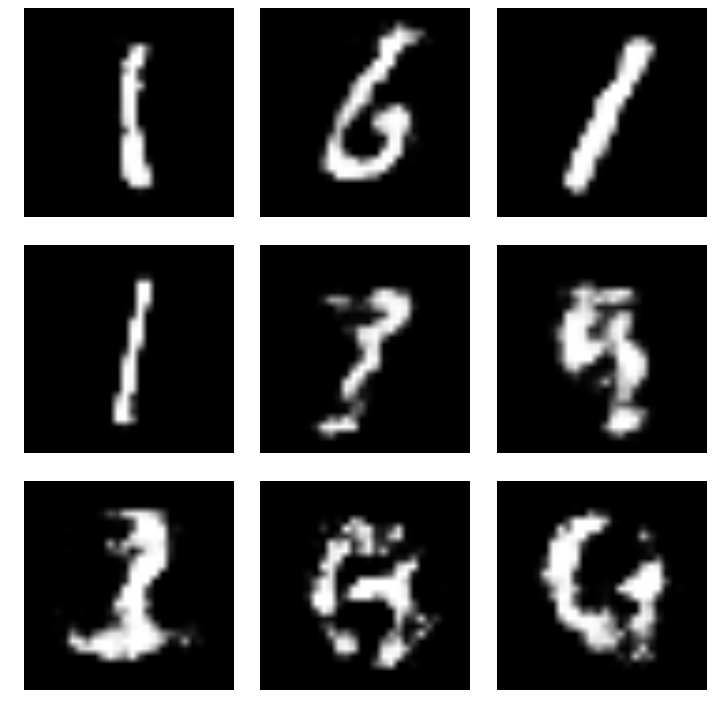

 83%|████████▎ | 5000/6000 [18:34<03:18,  5.04it/s]

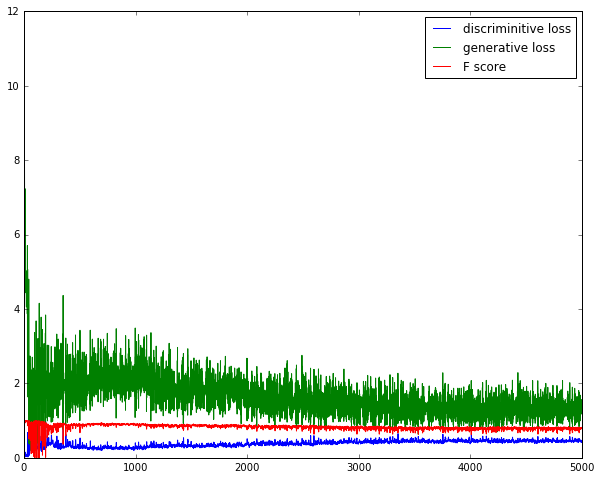

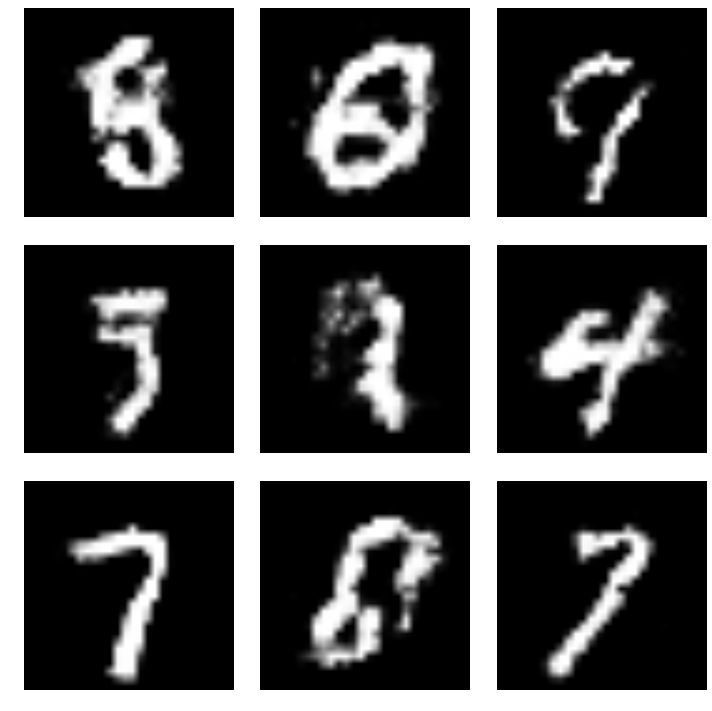

 92%|█████████▏| 5500/6000 [20:16<01:45,  4.75it/s]

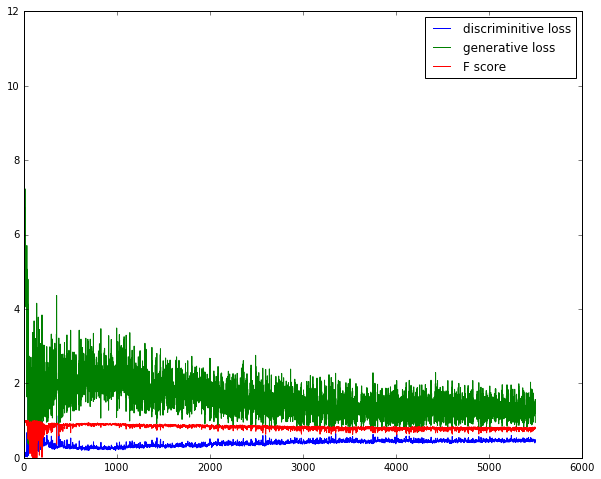

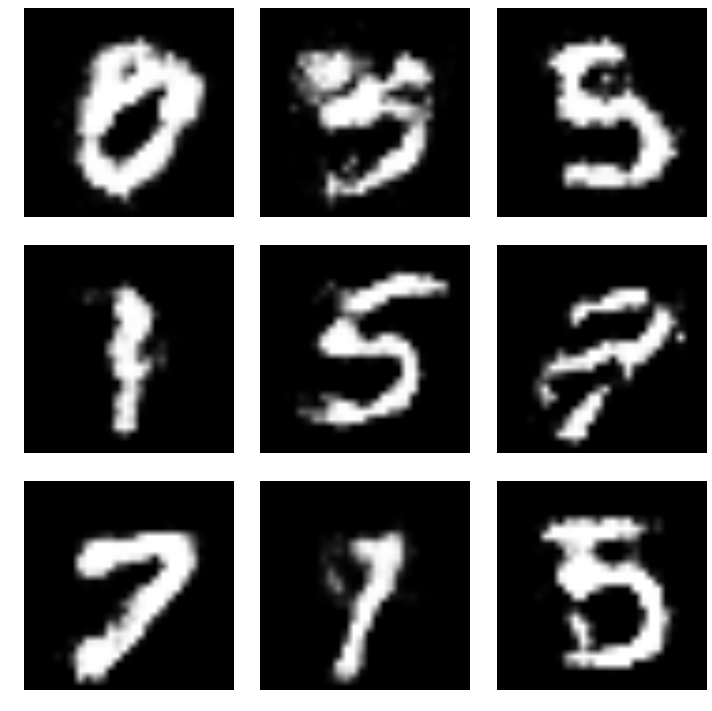

100%|██████████| 6000/6000 [21:56<00:00,  4.73it/s]

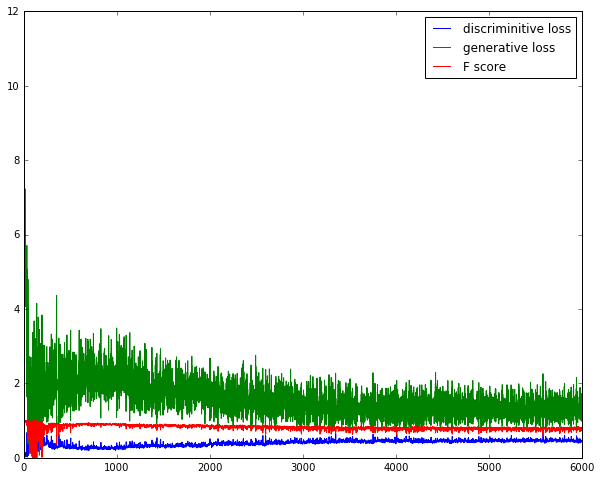

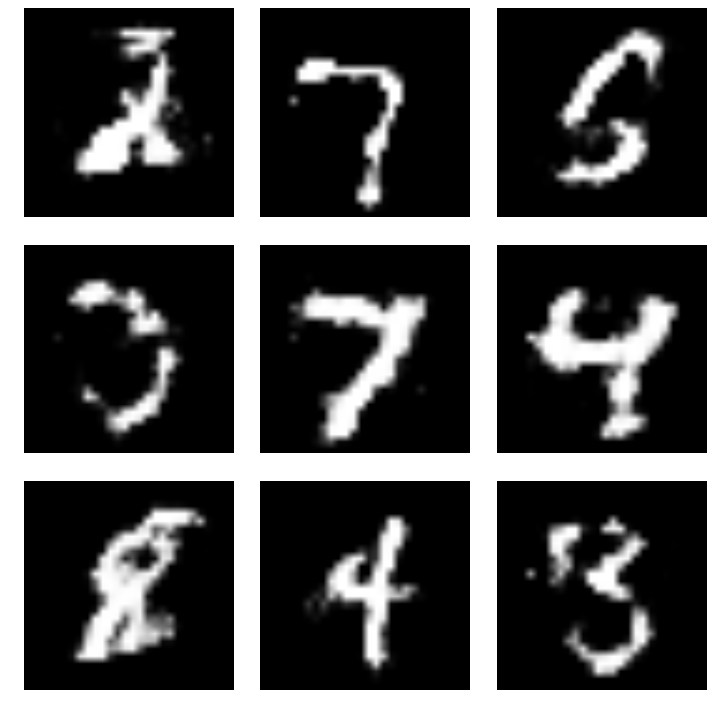

In [16]:
# Train generative adversarial net for 2,000 epochs with 300 batch size
# once the model trains with 2000 epochs, lower the learning rate
gen_losses = {"d":[], "g":[], "f":[]}
train_for_n(z_input=z_input_vector, generator_model=generator,
            discriminator_model=discriminator, gan_model=gan,
            z_training_figures=z_training_figures,
            z_group=z_group_matrix,
            z_plot_freq=z_plot_freq, visualize_train=True,
            loss_dict=gen_losses, X_train = X_real,
            epoch=epoch, plot_freq=plot_freq, batch=batch)

In [17]:
for im in range(len(z_training_figures)):
    z_training_figures[im].savefig('figures/training/training_gif_{}_.png'.format(im))